# Background

a specific idea that comes to mind:
What if we cast active learning as a semantic reranking problem? (relevant: Cohere is SOTA in reranking, e.g. above OpenAI and Anthropic)
Specifically, the step where you sample from an acquisition function and choose the next input to run can be cast as:
Consider your entire domain of possible experiments or a very high-recall subset of it in some discretized form, cast as a set of documents (i.e. JSON of inputs and predicted outputs from some forward predictive model)
Rerank the next possible experiments vs a query (e.g., the latest experiment(s) and result(s))
Then benchmark actual performance of:
vanilla reranker
finetuned reranker (e.g., showing positive examples from some classic ML algo, to distill that capability into the semantic reranker)
classic ML algo
The high level loop looks basically the same as the plan here. The advantages are that:
reranking is kind of an unusual way to do this but it is suuuuper cheap cost and latency wise, so if it works then that is a very relevant result. And like LLMs, if it is at least as good as classical, it means it is very generalizable since you don't need to worry about featurization since it's all natural language
finetuning is a strong moat since most people do not know how to do it effectively (and obv here is somewhere I can help with some cohere-informed pro tips)
I can probably find a way to get some cohere credits to cover the cost of production-level inference rate limits
11:20
^^^ 
@Hongchen Wang
 wdyt of this? It is probably doable ~immediately on your membrane project if there aren't any blockers
11:21
(it's basically the same as the plan for using o1, but trying something a bit unusual via trying a reranking setup vs a pure generative setup, which means the input space of candidate next-experiments must be discretized, but that's fine since we were planning that anyway)

finetuning is basically like:
given many sets of {query, document, correct_score}
train the model to predict the correct score
12:32
Although the reranking is generally trained to do stuff like question-answering, like if you query "what is the capital of US" over all of wikipedia, you should get the pages for DC and related pages





12:32
but by manipulating the pairings and the correct score, you can finetune the reranker to emit scores based on whatever you like, while retaining it's underlying semantic reasoning that has been pretrained into it
12:34
so there is probably a cool setup where we do something like:
convert experiment params and results into a markdown "report" (could use any LLM for this)
Summarize the experiments tried so far into a summary of findings plus a question, like "ok so these reagents didn't do so well and I think I should vary X next... what next experiment should I try?"
Then you rerank over the candidate possible markdown docs (which are experiments you could run, perhaps also with their predicted results generated via an LLM in markdown)
12:35
it's kinda of a crazy reframe of active learning into "what if everything is a short wiki style markdown document, and we are actually just doing ranking over real empirical documents and hypothetical future documents"
12:35
and the finetune data can just come from your past experiments where you know the results, translated into these markdown docs

# Initialize

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


# Load datasets

In [189]:
df = pd.read_csv('propertydata20240927tillbatch37nov21.csv')
df

,Name,Auto,Heating,Concentration,Batch,Sample,Trial,Thickness,Elastic Modulus,Yield Strength,Creep Strain,Plateau Slope,Densification Slope,Changepoint,Fit,Average Standard Deviation
0,Auto_noheating_10wt_3_1_1,True,False,10.00,3,1,1,109.0000,76.728733,8.035941,NaN,40.371877,990.455813,0.728571,True,53.797772
1,Auto_noheating_10wt_3_1_2,True,False,10.00,3,1,2,113.0000,86.010750,8.854239,NaN,48.653420,931.396721,0.703094,True,53.797772
2,Auto_noheating_10wt_3_1_3,True,False,10.00,3,1,3,107.0000,84.672400,8.199867,NaN,48.443704,977.255772,0.683290,True,53.797772
3,Auto_noheating_10wt_3_1_4,True,False,10.00,3,1,4,106.0000,134.939046,88.742717,NaN,795.632583,-69.850029,0.788129,False,53.797772
4,Auto_noheating_12wt_3_1_1,True,False,11.63,3,1,1,107.0000,88.268477,8.670033,NaN,43.708133,892.534617,0.664271,True,52.829720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,Auto_heating_15_36_1_3,True,True,15.00,36,1,3,115.9764,117.304863,10.950087,0.028252,78.602285,1087.690566,0.689427,True,56.663193
239,Auto_heating_15_36_1_4,True,True,15.00,36,1,4,117.7290,121.511233,11.210320,0.034304,92.193790,956.935936,0.665967,False,56.663193
240,Auto_heating_17_36_1_1,True,True,17.00,36,1,1,127.0254,176.661609,14.252450,0.043991,73.241317,1040.322244,0.565335,True,53.182789
241,Auto_heating_17_36_1_2,True,True,17.00,36,1,2,126.2634,178.138828,13.452987,0.046067,85.156251,953.551303,0.541922,True,53.182789


In [190]:
df_parameters = pd.read_csv('all_data_parameters_2024_11_26.csv')
df_parameters

,Auto,Heating,Concentration,Batch,Sample,Mixing Height and Lift Adjusted,Heated Container,Heated Block,Heating Block Temperature,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,True,False,10.00,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
1,True,False,11.63,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.010549
2,True,False,14.43,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.011184
3,True,False,17.00,3,1,1,0,0,25,False,4,0.0,1,0,2024-02-12,64,0,0,0.013384
4,True,False,10.00,4,1,1,0,0,25,True,1,0.0,1,0,2024-02-23,61,0,0,0.156273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,False,False,15.00,35,1,1,0,0,25,False,0,0.0,1,1,2024-11-18,50,0,0,0.190041
75,False,False,17.00,35,1,1,0,0,25,False,0,0.0,1,1,2024-11-18,50,0,0,0.139232
76,True,True,15.00,36,1,1,0,1,80,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
77,True,True,17.00,36,1,1,0,1,80,False,2,0.0,1,1,2024-11-20,58,0,0,0.047234


In [191]:
# merge the two dataframes on Auto, Heating, Concentration, Batch, Sample
data = pd.merge(df, df_parameters, on=['Auto', 'Heating', 'Concentration', 'Batch', 'Sample'])
# only keep Fit = True
data = data[data['Fit'] == True]
# heating
# data = data[data['Heating'] == False]
# Coupon-to-Bath Wait Time (min)
# data = data[data['Coupon-to-Bath Wait Time (min)'] == 0]
#data = data[data['Auto'] == True]
#only show date after 2024-10-16
#data = data[data['Date'] > '2024-09-20']
#data = data[data['Relative Humidity'] > 49]
# only take batch 31, 33, 34, 35
#data = data[data['Batch'].isin([31, 33, 34, 35, 36])]

data

,Name,Auto,Heating,Concentration,Batch,Sample,Trial,Thickness,Elastic Modulus,Yield Strength,...,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,Auto_noheating_10wt_3_1_1,True,False,10.00,3,1,1,109.0000,76.728733,8.035941,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
1,Auto_noheating_10wt_3_1_2,True,False,10.00,3,1,2,113.0000,86.010750,8.854239,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
2,Auto_noheating_10wt_3_1_3,True,False,10.00,3,1,3,107.0000,84.672400,8.199867,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
4,Auto_noheating_12wt_3_1_1,True,False,11.63,3,1,1,107.0000,88.268477,8.670033,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.010549
5,Auto_noheating_12wt_3_1_2,True,False,11.63,3,1,2,110.0000,99.227054,10.405136,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.010549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Auto_heating_15_36_1_1,True,True,15.00,36,1,1,110.6170,94.924662,9.078378,...,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
237,Auto_heating_15_36_1_2,True,True,15.00,36,1,2,115.5446,109.038526,10.173041,...,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
238,Auto_heating_15_36_1_3,True,True,15.00,36,1,3,115.9764,117.304863,10.950087,...,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
240,Auto_heating_17_36_1_1,True,True,17.00,36,1,1,127.0254,176.661609,14.252450,...,False,2,0.0,1,1,2024-11-20,58,0,0,0.047234


In [192]:
# Group by the specified columns and calculate mean and std for the required properties
data_grouped = data.groupby(['Auto', 'Heating', 'Concentration', 'Batch', 'Sample']).agg({
    'Elastic Modulus': ['mean', 'std'],
    'Yield Strength': ['mean', 'std'],
    'Creep Strain': ['mean', 'std'],
    'Plateau Slope': ['mean', 'std'],
    'Densification Slope': ['mean', 'std'],
    'Changepoint': ['mean', 'std'],
    'Average Standard Deviation': ['mean', 'std'],
    'Coefficient of Variation': ['mean', 'std']
})

# Flatten MultiIndex columns after aggregation
data_grouped.columns = ['_'.join(col).strip() for col in data_grouped.columns.values]
data_grouped = data_grouped.reset_index()

# Merge the grouped data with df_parameters
data_grouped = pd.merge(data_grouped, df_parameters, on=['Auto', 'Heating', 'Concentration', 'Batch', 'Sample'])
# shuffle
data_grouped = data_grouped.sample(frac=1, random_state=42).reset_index(drop=True)
data_grouped


,Auto,Heating,Concentration,Batch,Sample,Elastic Modulus_mean,Elastic Modulus_std,Yield Strength_mean,Yield Strength_std,Creep Strain_mean,...,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,True,False,15.00,32,1,179.780045,12.059961,42.843561,34.215705,0.025644,...,False,0,0.0,1,1,2024-11-14,46,0,0,0.248858
1,True,False,10.00,13,1,106.819343,NaN,14.184020,NaN,NaN,...,True,1,0.0,1,1,2024-07-24,80,1,0,0.164578
2,False,False,12.00,31,1,109.607330,18.699564,51.207371,3.225834,0.020446,...,False,0,0.0,1,1,2024-11-13,48,0,0,0.169626
3,False,False,17.00,16,2,255.042207,NaN,17.730913,NaN,0.044643,...,False,0,0.0,1,1,2024-08-30,87,0,0,0.033307
4,True,False,17.00,18,2,171.004694,6.907569,13.029225,0.590966,0.039766,...,False,0,0.0,1,1,2024-09-09,82,0,0,0.017871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,True,False,15.00,34,1,140.768713,24.681104,16.902020,9.655240,0.026833,...,True,1,0.0,1,1,2024-11-15,50,0,0,0.137876
63,True,False,10.00,32,1,50.104314,NaN,10.983408,NaN,0.012758,...,False,0,0.0,1,1,2024-11-14,46,0,0,0.000000
64,True,True,11.63,7,2,90.998710,9.505165,34.615127,17.245104,NaN,...,True,0,0.0,1,0,2024-03-20,69,0,0,0.236195
65,True,False,10.00,6,3,69.026405,8.279371,5.943005,1.921989,NaN,...,True,3,0.0,1,0,2024-03-01,55,0,0,0.262396


# Random

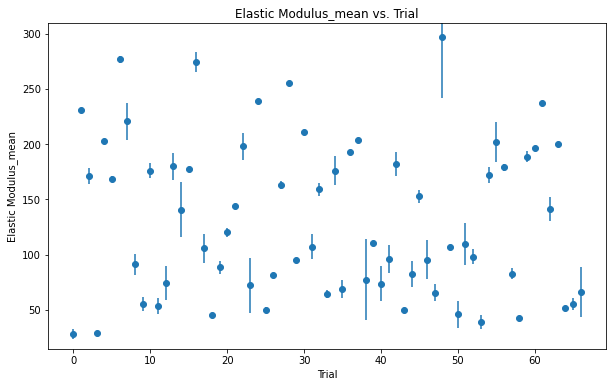

In [193]:
# shuffle the data 
data_grouped = data_grouped.sample(frac=1, random_state=42).reset_index(drop=True)
# plot Elastic Modulus_mean vs. a time axis, also add the error bars
plt.figure(figsize=(10, 6))
plt.errorbar(data_grouped.index, data_grouped['Elastic Modulus_mean'], yerr=data_grouped['Elastic Modulus_std'], fmt='o')
plt.xlabel('Trial')
plt.ylabel('Elastic Modulus_mean')
plt.title('Elastic Modulus_mean vs. Trial')
plt.show()


# Traditional ML

In [194]:
# Preprocessing 
X = data_grouped.drop([
    'Elastic Modulus_mean', 'Elastic Modulus_std', 'Yield Strength_mean',
    'Yield Strength_std', 'Creep Strain_mean', 'Creep Strain_std',
    'Plateau Slope_mean', 'Plateau Slope_std', 'Densification Slope_mean',
    'Densification Slope_std', 'Changepoint_mean', 'Changepoint_std', 'Date', 
    'Average Standard Deviation_mean', 'Average Standard Deviation_std',
    'Coefficient of Variation_mean', 'Coefficient of Variation_std',
    'Coefficient of Variation', 'Batch'
], axis=1)
y = data_grouped['Elastic Modulus_mean']
yerr = data_grouped['Elastic Modulus_std']

# Normalize input features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Initial training data
X_train = X.sample(10, random_state=42)
y_train = y[X_train.index]
yerr_train = yerr[X_train.index]
X_train_normalized = scaler.transform(X_train)


In [195]:
class ActiveLearningUCB:
    def __init__(self, kernel=None, alpha=1.0):
        """
        Initialize the active learning setup.

        Parameters:
        - kernel: The kernel for the Gaussian Process (default is RBF).
        - alpha: Exploration-exploitation tradeoff parameter.
        """
        self.alpha = alpha
        self.kernel = kernel if kernel else C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10)
        self.X_train = None
        self.y_train = None

    def update_model(self, X_train, y_train):
        """
        Update the regression model with new training data.
        
        Parameters:
        - X_train: Training input data.
        - y_train: Training target data.
        """
        self.X_train = X_train
        self.y_train = y_train
        self.model.fit(X_train, y_train)

    def ucb_acquisition(self, X_candidates):
        """
        Compute the UCB acquisition scores for candidate points.

        Parameters:
        - X_candidates: Candidate input data points.

        Returns:
        - UCB scores for all candidate points.
        """
        mean, std = self.model.predict(X_candidates, return_std=True)
        return mean + self.alpha * std

    def select_next_point(self, X_candidates):
        """
        Select the next query point based on the UCB criterion.

        Parameters:
        - X_candidates: Candidate input data points.

        Returns:
        - The index of the selected candidate point.
        """
        ucb_scores = self.ucb_acquisition(X_candidates)
        return np.argmax(ucb_scores), ucb_scores


Iteration 1: Selected index 34, Alpha: 3.00, MSE: 3757.075937
Iteration 2: Selected index 37, Alpha: 2.73, MSE: 5184.782878
Iteration 3: Selected index 16, Alpha: 2.50, MSE: 5185.159928
Iteration 4: Selected index 6, Alpha: 2.31, MSE: 9014.022530
Iteration 5: Selected index 61, Alpha: 2.14, MSE: 9014.037964
Iteration 6: Selected index 10, Alpha: 2.00, MSE: 9013.356903
Iteration 7: Selected index 13, Alpha: 1.88, MSE: 9979.253652
Iteration 8: Selected index 4, Alpha: 1.76, MSE: 9977.185827
Iteration 9: Selected index 7, Alpha: 1.67, MSE: 9524.157918
Iteration 10: Selected index 36, Alpha: 1.58, MSE: 9517.578878
Iteration 11: Selected index 55, Alpha: 1.50, MSE: 10313.914516
Iteration 12: Selected index 5, Alpha: 1.43, MSE: 10314.790406
Iteration 13: Selected index 45, Alpha: 1.36, MSE: 10313.891806
Iteration 14: Selected index 46, Alpha: 1.30, MSE: 10508.999696
Iteration 15: Selected index 39, Alpha: 1.25, MSE: 10502.633209
Iteration 16: Selected index 21, Alpha: 1.20, MSE: 11808.417200

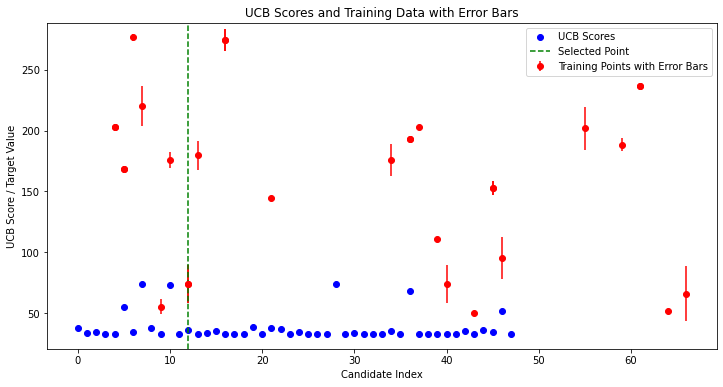

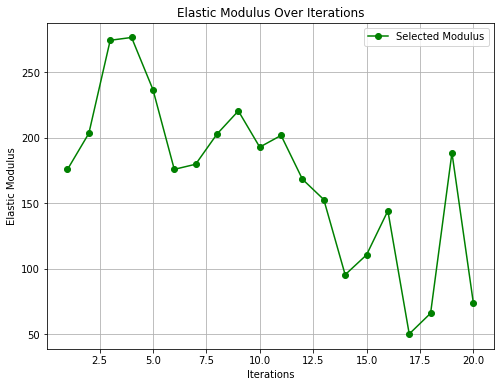

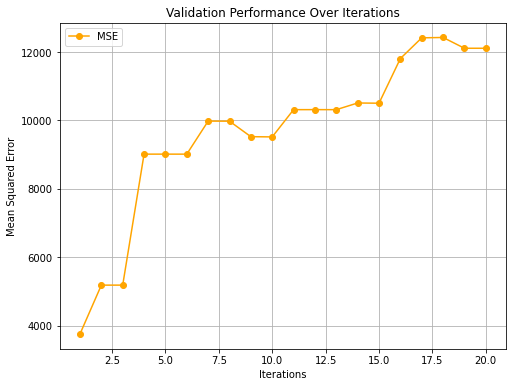

In [196]:
# Initialize the active learning model
al_model = ActiveLearningUCB()
al_model.update_model(X_train_normalized, y_train.values)

# Active learning loop parameters
max_iterations = 20  # Maximum number of iterations
X_candidates = X_normalized  # All normalized data
selected_indices = []  # To track selected points
iteration_indices = []  # To store iteration numbers
selected_modulus = []  # Store the Elastic Modulus of the selected points
mse_per_iteration = []  # Store MSE values for validation
early_stopping_threshold = 1e-4  # Threshold for early stopping

# Validation set
X_validation = scaler.transform(X)  # Replace with a proper validation set if available
y_validation = y.values  # Replace with validation targets

for iteration in range(max_iterations):
    # Dynamic Alpha Adjustment
    al_model.alpha = max(1, 3 / (1 + iteration * 0.1))  # Exponential decay of alpha

    # Filter candidates to exclude already selected points
    available_indices = [i for i in range(len(X_candidates)) if i not in selected_indices]
    X_candidates_filtered = X_candidates[available_indices]

    # Select the next point based on UCB
    selected_idx_local, ucb_scores = al_model.select_next_point(X_candidates_filtered)
    selected_idx = available_indices[selected_idx_local]  # Map back to original indices

    # Save iteration index and selected modulus
    iteration_indices.append(iteration + 1)
    selected_indices.append(selected_idx)
    selected_modulus.append(y.iloc[selected_idx])

    # Add selected point to the training set
    X_new = X.iloc[[selected_idx]]
    y_new = y.iloc[[selected_idx]]
    yerr_new = yerr.iloc[[selected_idx]]

    X_new_normalized = scaler.transform(X_new)
    X_train_normalized = np.vstack([X_train_normalized, X_new_normalized])

    X_train = pd.concat([X_train, X_new])
    y_train = pd.concat([y_train, y_new])
    yerr_train = pd.concat([yerr_train, yerr_new])

    # Update the model with the new training set
    al_model.update_model(X_train_normalized, y_train.values)

    # Performance Validation: Calculate MSE on validation data
    predictions = al_model.model.predict(X_validation)
    mse = mean_squared_error(y_validation, predictions)
    mse_per_iteration.append(mse)

    print(f"Iteration {iteration + 1}: Selected index {selected_idx}, Alpha: {al_model.alpha:.2f}, MSE: {mse:.6f}")

    # Early Stopping Criterion
    if len(mse_per_iteration) > 1 and abs(mse_per_iteration[-1] - mse_per_iteration[-2]) < early_stopping_threshold:
        print(f"Stopping early at iteration {iteration + 1} due to minimal improvement in MSE.")
        break

# Plot UCB Scores and Training Data with Error Bars
plt.figure(figsize=(12, 6))
plt.errorbar(X_train.index, y_train, yerr=yerr_train, fmt='o', color='red', label="Training Points with Error Bars")
plt.scatter(range(len(ucb_scores)), ucb_scores, label="UCB Scores", color="blue")
plt.axvline(x=selected_idx, color="green", linestyle="--", label="Selected Point")
plt.xlabel("Candidate Index")
plt.ylabel("UCB Score / Target Value")
plt.title("UCB Scores and Training Data with Error Bars")
plt.legend()
plt.show()

# Plot Modulus vs. Iterations
plt.figure(figsize=(8, 6))
plt.plot(iteration_indices, selected_modulus, marker='o', label="Selected Modulus", color="green")
plt.xlabel("Iterations")
plt.ylabel("Elastic Modulus")
plt.title("Elastic Modulus Over Iterations")
plt.legend()
plt.grid()
plt.show()

# Plot MSE vs. Iterations
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(mse_per_iteration) + 1), mse_per_iteration, marker='o', label="MSE", color="orange")
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error")
plt.title("Validation Performance Over Iterations")
plt.legend()
plt.grid()
plt.show()


# Modularized Code

2025-01-14 12:11:55,906 - INFO - Iteration 1: Alpha=3.00
2025-01-14 12:11:55,956 - INFO - Iteration 1: Selected Index=37, MSE=13583.930401
2025-01-14 12:11:55,957 - INFO - Iteration 2: Alpha=2.73
2025-01-14 12:11:56,001 - INFO - Iteration 2: Selected Index=16, MSE=13583.930892
2025-01-14 12:11:56,001 - INFO - Iteration 3: Alpha=2.50
2025-01-14 12:11:56,065 - INFO - Iteration 3: Selected Index=13, MSE=14387.285560
2025-01-14 12:11:56,065 - INFO - Iteration 4: Alpha=2.31
2025-01-14 12:11:56,115 - INFO - Iteration 4: Selected Index=6, MSE=14371.012947
2025-01-14 12:11:56,116 - INFO - Iteration 5: Alpha=2.14
2025-01-14 12:11:56,159 - INFO - Iteration 5: Selected Index=61, MSE=13503.183307


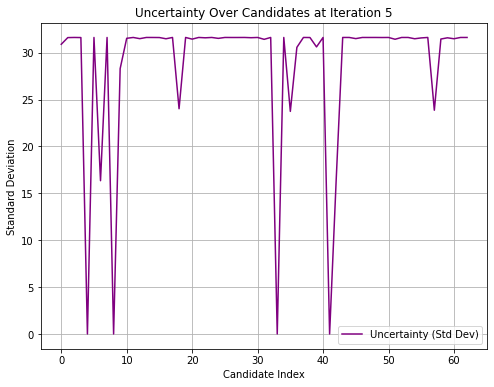

2025-01-14 12:11:56,256 - INFO - Iteration 6: Alpha=2.00
2025-01-14 12:11:56,347 - INFO - Iteration 6: Selected Index=4, MSE=13500.763322
2025-01-14 12:11:56,347 - INFO - Iteration 7: Alpha=1.88
2025-01-14 12:11:56,429 - INFO - Iteration 7: Selected Index=36, MSE=13503.246625
2025-01-14 12:11:56,429 - INFO - Iteration 8: Alpha=1.76
2025-01-14 12:11:56,508 - INFO - Iteration 8: Selected Index=7, MSE=12542.454214
2025-01-14 12:11:56,508 - INFO - Iteration 9: Alpha=1.67
2025-01-14 12:11:56,601 - INFO - Iteration 9: Selected Index=10, MSE=12210.699044
2025-01-14 12:11:56,601 - INFO - Iteration 10: Alpha=1.58
2025-01-14 12:11:56,723 - INFO - Iteration 10: Selected Index=45, MSE=12210.726837


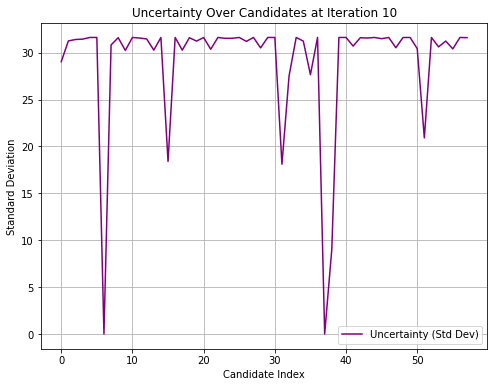

2025-01-14 12:11:56,816 - INFO - Iteration 11: Alpha=1.50
2025-01-14 12:11:56,960 - INFO - Iteration 11: Selected Index=46, MSE=12528.661183
2025-01-14 12:11:56,961 - INFO - Iteration 12: Alpha=1.43
2025-01-14 12:11:57,044 - INFO - Iteration 12: Selected Index=34, MSE=11434.258785
2025-01-14 12:11:57,044 - INFO - Iteration 13: Alpha=1.36
2025-01-14 12:11:57,103 - INFO - Iteration 13: Selected Index=55, MSE=12018.437923
2025-01-14 12:11:57,104 - INFO - Iteration 14: Alpha=1.30
2025-01-14 12:11:57,232 - INFO - Iteration 14: Selected Index=27, MSE=11465.054011
2025-01-14 12:11:57,232 - INFO - Iteration 15: Alpha=1.25
2025-01-14 12:11:57,326 - INFO - Iteration 15: Selected Index=14, MSE=11439.894811


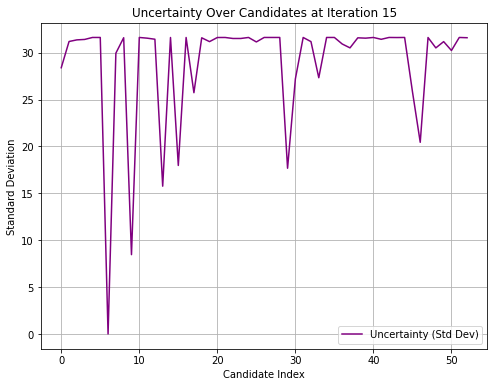

2025-01-14 12:11:57,416 - INFO - Iteration 16: Alpha=1.20
2025-01-14 12:11:57,512 - INFO - Iteration 16: Selected Index=19, MSE=12165.542455
2025-01-14 12:11:57,513 - INFO - Iteration 17: Alpha=1.15
2025-01-14 12:11:57,624 - INFO - Iteration 17: Selected Index=59, MSE=12073.274858
2025-01-14 12:11:57,624 - INFO - Iteration 18: Alpha=1.11
2025-01-14 12:11:57,754 - INFO - Iteration 18: Selected Index=39, MSE=11726.438104
2025-01-14 12:11:57,754 - INFO - Iteration 19: Alpha=1.07
2025-01-14 12:11:57,893 - INFO - Iteration 19: Selected Index=21, MSE=12126.879097
2025-01-14 12:11:57,893 - INFO - Iteration 20: Alpha=1.03
2025-01-14 12:11:57,954 - INFO - Iteration 20: Selected Index=43, MSE=12194.588081


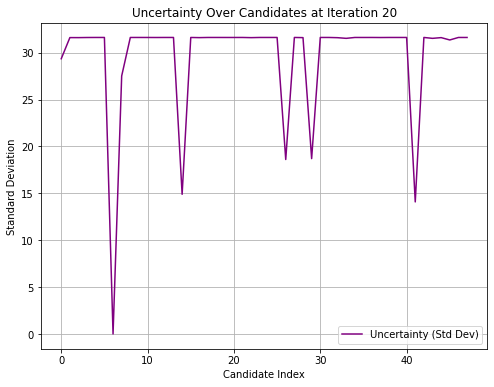

2025-01-14 12:11:58,044 - INFO - Iteration 21: Alpha=1.00
2025-01-14 12:11:58,133 - INFO - Iteration 21: Selected Index=9, MSE=12194.649844
2025-01-14 12:11:58,133 - INFO - Iteration 22: Alpha=1.00
2025-01-14 12:11:58,244 - INFO - Iteration 22: Selected Index=62, MSE=11770.044880
2025-01-14 12:11:58,244 - INFO - Iteration 23: Alpha=1.00
2025-01-14 12:11:58,355 - INFO - Iteration 23: Selected Index=49, MSE=11767.872735
2025-01-14 12:11:58,355 - INFO - Iteration 24: Alpha=1.00
2025-01-14 12:11:58,403 - INFO - Iteration 24: Selected Index=32, MSE=11408.363080
2025-01-14 12:11:58,403 - INFO - Iteration 25: Alpha=1.00
2025-01-14 12:11:58,444 - INFO - Iteration 25: Selected Index=1, MSE=10642.822053


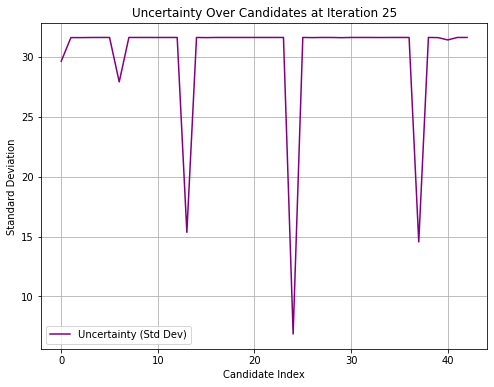

2025-01-14 12:11:58,530 - INFO - Iteration 26: Alpha=1.00
2025-01-14 12:11:58,609 - INFO - Iteration 26: Selected Index=63, MSE=10081.272732
2025-01-14 12:11:58,610 - INFO - Iteration 27: Alpha=1.00
2025-01-14 12:11:58,682 - INFO - Iteration 27: Selected Index=2, MSE=9331.806101
2025-01-14 12:11:58,682 - INFO - Iteration 28: Alpha=1.00
2025-01-14 12:11:58,750 - INFO - Iteration 28: Selected Index=42, MSE=9195.364074
2025-01-14 12:11:58,750 - INFO - Iteration 29: Alpha=1.00
2025-01-14 12:11:58,872 - INFO - Iteration 29: Selected Index=50, MSE=9164.408123
2025-01-14 12:11:58,872 - INFO - Iteration 30: Alpha=1.00
2025-01-14 12:11:59,107 - INFO - Iteration 30: Selected Index=25, MSE=9139.647303


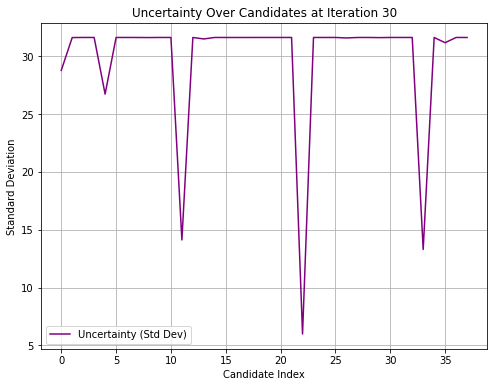

2025-01-14 12:11:59,205 - INFO - Iteration 31: Alpha=1.00
2025-01-14 12:11:59,463 - INFO - Iteration 31: Selected Index=29, MSE=8263.794052
2025-01-14 12:11:59,464 - INFO - Iteration 32: Alpha=1.00
2025-01-14 12:11:59,578 - INFO - Iteration 32: Selected Index=30, MSE=8140.801285
2025-01-14 12:11:59,579 - INFO - Iteration 33: Alpha=1.00
2025-01-14 12:11:59,769 - INFO - Iteration 33: Selected Index=51, MSE=7811.477657
2025-01-14 12:11:59,769 - INFO - Iteration 34: Alpha=1.00
2025-01-14 12:11:59,892 - INFO - Iteration 34: Selected Index=17, MSE=7801.046329
2025-01-14 12:11:59,892 - INFO - Iteration 35: Alpha=1.00
2025-01-14 12:12:00,033 - INFO - Iteration 35: Selected Index=12, MSE=7767.898055


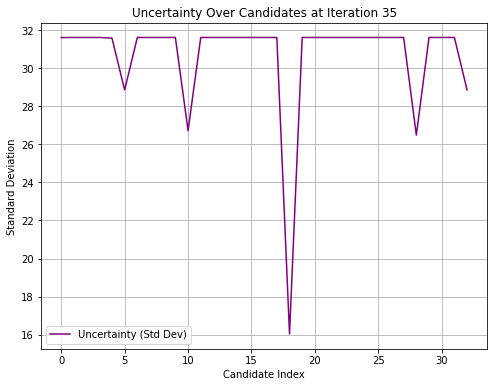

2025-01-14 12:12:00,136 - INFO - Iteration 36: Alpha=1.00
2025-01-14 12:12:00,265 - INFO - Iteration 36: Selected Index=66, MSE=7767.914116
2025-01-14 12:12:00,266 - INFO - Iteration 37: Alpha=1.00
2025-01-14 12:12:00,334 - INFO - Iteration 37: Selected Index=40, MSE=7747.043783
2025-01-14 12:12:00,334 - INFO - Iteration 38: Alpha=1.00
2025-01-14 12:12:00,490 - INFO - Iteration 38: Selected Index=23, MSE=7657.300010
2025-01-14 12:12:00,490 - INFO - Iteration 39: Alpha=1.00
2025-01-14 12:12:00,604 - INFO - Iteration 39: Selected Index=58, MSE=7651.568124
2025-01-14 12:12:00,604 - INFO - Iteration 40: Alpha=1.00
2025-01-14 12:12:00,737 - INFO - Iteration 40: Selected Index=0, MSE=7653.968663


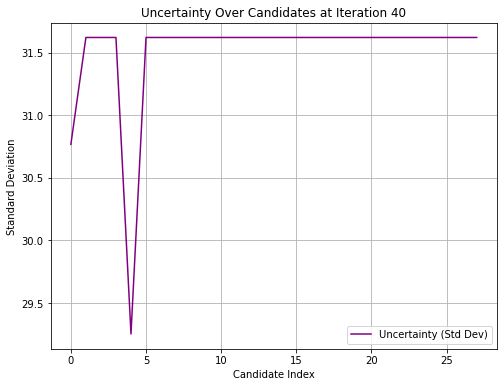

2025-01-14 12:12:00,828 - INFO - Iteration 41: Alpha=1.00
2025-01-14 12:12:01,000 - INFO - Iteration 41: Selected Index=11, MSE=7634.758460
2025-01-14 12:12:01,000 - INFO - Iteration 42: Alpha=1.00
2025-01-14 12:12:01,207 - INFO - Iteration 42: Selected Index=64, MSE=7594.971590
2025-01-14 12:12:01,208 - INFO - Iteration 43: Alpha=1.00
2025-01-14 12:12:01,316 - INFO - Iteration 43: Selected Index=53, MSE=7567.122895
2025-01-14 12:12:01,317 - INFO - Iteration 44: Alpha=1.00
2025-01-14 12:12:01,407 - INFO - Iteration 44: Selected Index=18, MSE=7540.875811
2025-01-14 12:12:01,407 - INFO - Iteration 45: Alpha=1.00
2025-01-14 12:12:01,642 - INFO - Iteration 45: Selected Index=3, MSE=7529.310361


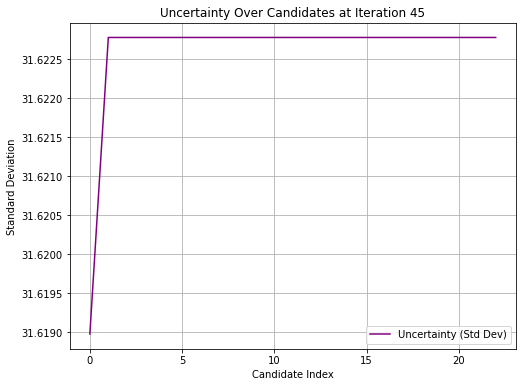

2025-01-14 12:12:01,739 - INFO - Iteration 46: Alpha=1.00
2025-01-14 12:12:01,820 - INFO - Iteration 46: Selected Index=48, MSE=6216.980385
2025-01-14 12:12:01,820 - INFO - Iteration 47: Alpha=1.00
2025-01-14 12:12:02,020 - INFO - Iteration 47: Selected Index=26, MSE=6117.253574
2025-01-14 12:12:02,020 - INFO - Iteration 48: Alpha=1.00
2025-01-14 12:12:02,206 - INFO - Iteration 48: Selected Index=44, MSE=6015.653933
2025-01-14 12:12:02,206 - INFO - Iteration 49: Alpha=1.00
2025-01-14 12:12:02,302 - INFO - Iteration 49: Selected Index=28, MSE=5044.803365
2025-01-14 12:12:02,303 - INFO - Iteration 50: Alpha=1.00
2025-01-14 12:12:02,460 - INFO - Iteration 50: Selected Index=24, MSE=4195.218725


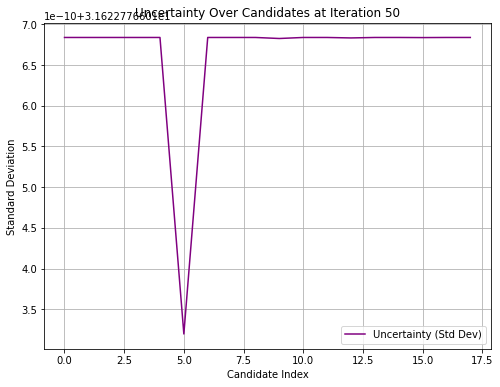

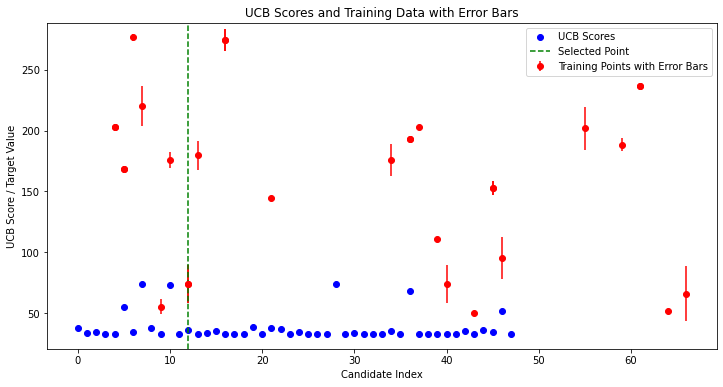

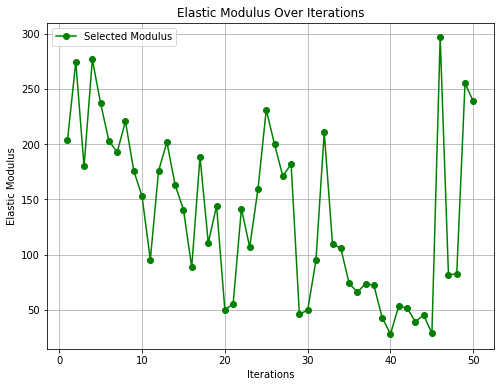

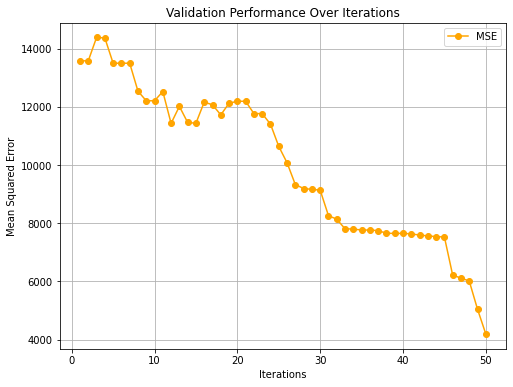

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define the Active Learning UCB class
class ActiveLearningUCB:
    def __init__(self, kernel=None, alpha=1.0):
        self.alpha = alpha
        self.kernel = kernel if kernel else C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def ucb_acquisition(self, X_candidates):
        mean, std = self.model.predict(X_candidates, return_std=True)
        return mean + self.alpha * std, mean, std

    def select_next_point(self, X_candidates):
        ucb_scores, mean, std = self.ucb_acquisition(X_candidates)
        return np.argmax(ucb_scores), ucb_scores, mean, std


# Preprocessing
def preprocess_data(data):
    X = data.drop([
        'Elastic Modulus_mean', 'Elastic Modulus_std', 'Yield Strength_mean',
        'Yield Strength_std', 'Creep Strain_mean', 'Creep Strain_std',
        'Plateau Slope_mean', 'Plateau Slope_std', 'Densification Slope_mean',
        'Densification Slope_std', 'Changepoint_mean', 'Changepoint_std', 'Date',
        'Average Standard Deviation_mean', 'Average Standard Deviation_std',
        'Coefficient of Variation_mean', 'Coefficient of Variation_std',
        'Coefficient of Variation', 'Batch'
    ], axis=1)
    y = data['Elastic Modulus_mean']
    yerr = data['Elastic Modulus_std']
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    return X, y, yerr, X_normalized, scaler


# Active Learning Loop
def run_active_learning(data, initial_train_point = 10, max_iterations=20, alpha_initial=3, alpha_decay=0.1, early_stopping_threshold=1e-4):
    # Preprocess data
    X, y, yerr, X_normalized, scaler = preprocess_data(data)

    # Initial training data
    X_train = X.sample(initial_train_point, random_state=42)
    y_train = y[X_train.index]
    yerr_train = yerr[X_train.index]
    X_train_normalized = scaler.transform(X_train)

    # Initialize Active Learning Model
    al_model = ActiveLearningUCB(alpha=alpha_initial)
    al_model.update_model(X_train_normalized, y_train.values)

    # Initialize tracking variables
    selected_indices = []
    iteration_indices = []
    selected_modulus = []
    mse_per_iteration = []
    prev_std_mean = None  # To track uncertainty reduction

    for iteration in range(max_iterations):
        # Dynamic Alpha Adjustment
        al_model.alpha = max(1, alpha_initial / (1 + iteration * alpha_decay))
        logging.info(f"Iteration {iteration + 1}: Alpha={al_model.alpha:.2f}")

        # Filter candidates to exclude already selected points
        available_indices = [i for i in range(len(X_normalized)) if i not in selected_indices] # no duplicate selection
        #available_indices = [i for i in range(len(X_normalized))] # duplicate selection
        X_candidates_filtered = X_normalized[available_indices]

        # Select the next point
        selected_idx_local, ucb_scores, mean, std = al_model.select_next_point(X_candidates_filtered)
        selected_idx = available_indices[selected_idx_local]

        # Save selected point information
        iteration_indices.append(iteration + 1)
        selected_indices.append(selected_idx)
        selected_modulus.append(y.iloc[selected_idx])

        # Update training data
        X_new = X.iloc[[selected_idx]]
        y_new = y.iloc[[selected_idx]]
        yerr_new = yerr.iloc[[selected_idx]]

        X_new_normalized = scaler.transform(X_new)
        X_train_normalized = np.vstack([X_train_normalized, X_new_normalized])

        X_train = pd.concat([X_train, X_new])
        y_train = pd.concat([y_train, y_new])
        yerr_train = pd.concat([yerr_train, yerr_new])

        al_model.update_model(X_train_normalized, y_train.values)

        # Performance Validation
        predictions = al_model.model.predict(X_normalized)
        mse = mean_squared_error(y, predictions)
        mse_per_iteration.append(mse)
        logging.info(f"Iteration {iteration + 1}: Selected Index={selected_idx}, MSE={mse:.6f}")

        # Check Early Stopping Criterion
        if len(mse_per_iteration) > 1 and abs(mse_per_iteration[-1] - mse_per_iteration[-2]) < early_stopping_threshold:
            logging.info(f"Stopping early at iteration {iteration + 1} due to minimal improvement in MSE.")
            break

        # Uncertainty Visualization (optional per iteration)
        if iteration == max_iterations - 1 or (iteration + 1) % 5 == 0:  # Plot every 5 iterations
            plt.figure(figsize=(8, 6))
            plt.plot(range(len(std)), std, label="Uncertainty (Std Dev)", color="purple")
            plt.xlabel("Candidate Index")
            plt.ylabel("Standard Deviation")
            plt.title(f"Uncertainty Over Candidates at Iteration {iteration + 1}")
            plt.legend()
            plt.grid()
            plt.show()

    # Final Visualizations
    plot_results(iteration_indices, selected_modulus, mse_per_iteration)


# Plot Results
def plot_results(iteration_indices, selected_modulus, mse_per_iteration):
    # Plot UCB Scores and Training Data with Error Bars
    plt.figure(figsize=(12, 6))
    plt.errorbar(X_train.index, y_train, yerr=yerr_train, fmt='o', color='red', label="Training Points with Error Bars")
    plt.scatter(range(len(ucb_scores)), ucb_scores, label="UCB Scores", color="blue")
    plt.axvline(x=selected_idx, color="green", linestyle="--", label="Selected Point")
    plt.xlabel("Candidate Index")
    plt.ylabel("UCB Score / Target Value")
    plt.title("UCB Scores and Training Data with Error Bars")
    plt.legend()
    plt.show()
    # Plot Modulus vs. Iterations
    plt.figure(figsize=(8, 6))
    plt.plot(iteration_indices, selected_modulus, marker='o', label="Selected Modulus", color="green")
    plt.xlabel("Iterations")
    plt.ylabel("Elastic Modulus")
    plt.title("Elastic Modulus Over Iterations")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot MSE vs. Iterations
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(mse_per_iteration) + 1), mse_per_iteration, marker='o', label="MSE", color="orange")
    plt.xlabel("Iterations")
    plt.ylabel("Mean Squared Error")
    plt.title("Validation Performance Over Iterations")
    plt.legend()
    plt.grid()
    plt.show()


run_active_learning(data_grouped, initial_train_point=5, max_iterations=50, alpha_initial=3, alpha_decay=0.1, early_stopping_threshold=1e-4)


# LLM - Cohere Reranking